In [1]:
!pip install pandas requests python-dotenv tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [python-dotenv]


In [2]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv
from tqdm import tqdm


In [3]:
load_dotenv()

AQS_EMAIL = os.getenv("AQS_EMAIL")
AQS_KEY   = os.getenv("AQS_KEY")

print("AQS Email Loaded:", AQS_EMAIL is not None)
print("AQS Key Loaded:", AQS_KEY is not None)


AQS Email Loaded: True
AQS Key Loaded: True


In [4]:
BASE_AQS_URL = "https://aqs.epa.gov/data/api"

COUNTIES = [
    {"name": "Los Angeles County, CA", "state_fips": "06", "county_fips": "037"},
    {"name": "Harris County, TX",      "state_fips": "48", "county_fips": "201"},
    {"name": "Cook County, IL",        "state_fips": "17", "county_fips": "031"},
    {"name": "Maricopa County, AZ",    "state_fips": "04", "county_fips": "013"},
]

YEARS = list(range(2018, 2024))


In [5]:
def get_pm25_for_county_year(state_fips, county_fips, year):
    url = f"{BASE_AQS_URL}/dailyData/byCounty"
    
    params = {
        "email": AQS_EMAIL,
        "key": AQS_KEY,
        "param": "88101",        # PM2.5
        "bdate": f"{year}0101",
        "edate": f"{year}1231",
        "state": state_fips,
        "county": county_fips
    }
    
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()

    if "Data" not in data or len(data["Data"]) == 0:
        return pd.DataFrame()

    df = pd.DataFrame(data["Data"])
    df["arithmetic_mean"] = pd.to_numeric(df["arithmetic_mean"], errors="coerce")
    return df


In [6]:
pm25_rows = []

for county in tqdm(COUNTIES):
    for year in YEARS:
        df_daily = get_pm25_for_county_year(
            county["state_fips"],
            county["county_fips"],
            year
        )
        
        if df_daily.empty:
            continue
        
        annual_mean = df_daily["arithmetic_mean"].mean()

        pm25_rows.append({
            "county_name": county["name"],
            "state_fips": county["state_fips"],
            "county_fips": county["county_fips"],
            "year": year,
            "annual_pm25": annual_mean
        })

pm25_df = pd.DataFrame(pm25_rows)
pm25_df


100%|██████████| 4/4 [10:03<00:00, 150.76s/it]


,county_name,state_fips,county_fips,year,annual_pm25
0,"Los Angeles County, CA",06,037,2018,11.924489
1,"Los Angeles County, CA",06,037,2019,10.113096
2,"Los Angeles County, CA",06,037,2020,13.435450
3,"Los Angeles County, CA",06,037,2021,12.161321
4,"Los Angeles County, CA",06,037,2022,10.929975
5,"Los Angeles County, CA",06,037,2023,10.031451
6,"Harris County, TX",48,201,2018,9.709892
7,"Harris County, TX",48,201,2019,9.400986
8,"Harris County, TX",48,201,2020,9.932420
9,"Harris County, TX",48,201,2021,9.955272


In [7]:
output_path = "../data/epa_pm25_annual_by_county.csv"
pm25_df.to_csv(output_path, index=False)

print("✅ EPA dataset saved to:", output_path)


✅ EPA dataset saved to: ../data/epa_pm25_annual_by_county.csv


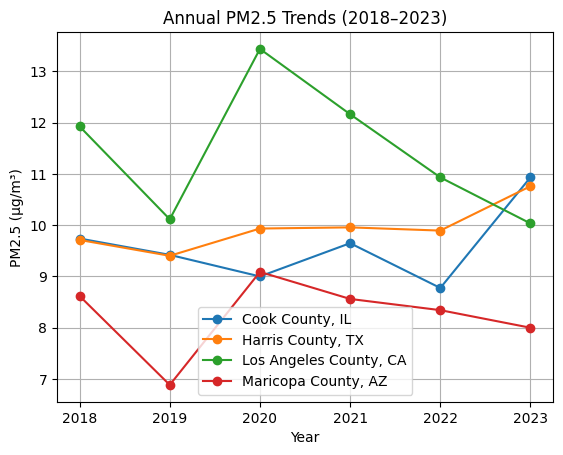

In [8]:
import matplotlib.pyplot as plt

for name, grp in pm25_df.groupby("county_name"):
    plt.plot(grp["year"], grp["annual_pm25"], marker="o", label=name)

plt.legend()
plt.title("Annual PM2.5 Trends (2018–2023)")
plt.xlabel("Year")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid(True)
plt.show()
